In [41]:
import pandas as pd
import biogeme.database as db
import biogeme.biogeme as bio
from biogeme.expressions import Derive, Beta, Variable, log, exp
from biogeme import models
from biogeme import results as res
from biogeme.expressions import Derive

In [2]:
#data_file = "http://transp-or.epfl.ch/data/lpmc.dat"
data_file='lpmc10.dat'
lpmc = pd.read_csv(data_file, sep='\t')
lpmc

,trip_id,household_id,person_n,trip_n,travel_mode,purpose,fueltype,faretype,bus_scale,survey_year,...,dur_pt_access,dur_pt_rail,dur_pt_bus,dur_pt_int,pt_interchanges,dur_driving,cost_transit,cost_driving_fuel,cost_driving_ccharge,driving_traffic_percent
0,20,5,1,0,4,3,1,5,0.0,1,...,0.381667,0.000000,0.062222,0.000000,0,0.117222,0.00,0.41,0.0,0.097156
1,41,9,3,0,4,3,1,5,0.0,1,...,0.146944,0.000000,0.225000,0.000000,0,0.200833,0.00,0.48,0.0,0.378976
2,69,13,2,1,4,3,1,1,1.0,1,...,0.029444,0.083333,0.735833,0.398056,3,0.716944,6.00,2.16,0.0,0.582720
3,102,20,2,0,2,3,1,1,1.0,1,...,0.339722,0.183333,0.116667,0.266667,1,0.250833,3.00,0.89,0.0,0.170543
4,105,21,0,1,4,3,1,1,1.0,1,...,0.126389,0.000000,0.150000,0.000000,0,0.125833,1.50,0.37,0.0,0.154525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,80998,17591,0,5,4,3,1,5,0.0,3,...,0.189167,0.000000,0.117778,0.000000,0,0.082500,0.00,0.22,10.5,0.239057
4996,81000,17592,0,0,3,3,6,5,0.0,3,...,0.105278,0.000000,0.220278,0.000000,0,0.213611,0.00,0.52,0.0,0.412224
4997,81015,17597,0,3,4,3,1,5,0.0,3,...,0.343056,0.000000,0.177500,0.000000,0,0.189444,0.00,0.76,0.0,0.086510
4998,81041,17604,2,4,3,1,1,2,0.0,3,...,0.344444,0.316667,0.000000,0.083333,1,0.386111,1.05,0.98,0.0,0.340288


In [4]:
# cost_driving = cost_driving_fuel + cost_driving_ccharge #total costs of driving
# dur_public = dur_pt_access + dur_pt_rail + dur_pt_bus + dur_pt_int #total duration of public transportation
# lpmc['cost_driving']=lpmc['cost_driving_ccharge']+lpmc['cost_driving_fuel']
# lpmc['dur_public']=lpmc['dur_pt_access']+lpmc['dur_pt_rail']+lpmc['dur_pt_bus']+lpmc['dur_pt_int']

In [3]:
database = db.Database('trips', lpmc)

In [4]:
lpmc.columns

Index(['trip_id', 'household_id', 'person_n', 'trip_n', 'travel_mode',
       'purpose', 'fueltype', 'faretype', 'bus_scale', 'survey_year',
       'travel_year', 'travel_month', 'travel_date', 'day_of_week',
       'start_time', 'age', 'female', 'driving_license', 'car_ownership',
       'distance', 'dur_walking', 'dur_cycling', 'dur_pt_access',
       'dur_pt_rail', 'dur_pt_bus', 'dur_pt_int', 'pt_interchanges',
       'dur_driving', 'cost_transit', 'cost_driving_fuel',
       'cost_driving_ccharge', 'driving_traffic_percent'],
      dtype='object')

In [5]:
# define variables
for col in lpmc.columns:
    globals()[col]=Variable(col)

In [6]:
cost_driving = database.DefineVariable('cost_driving',cost_driving_fuel + cost_driving_ccharge)
dur_public = database.DefineVariable('dur_public', dur_pt_access + dur_pt_rail + dur_pt_bus + dur_pt_int)

# Choice availability

In [7]:
law_violators =(lpmc['driving_license']==0 )& (lpmc['travel_mode']==4)
law_violators.value_counts()

False    4511
True      489
dtype: int64

# Model 0

In [8]:
asc_walk = Beta('asc_walk', 0, None, None, 1)
asc_cycling = Beta('asc_cycling', 0, None, None, 0)
asc_public = Beta('asc_public', 0, None, None, 0)
asc_driving = Beta('asc_driving', 0, None, None, 0)

In [9]:
beta_cost = Beta('beta_cost', 0, None, None, 0)
beta_time = Beta('beta_time', 0, None, None, 0)

In [10]:
V_walk = asc_walk + beta_time * dur_walking
V_cycling = asc_cycling + beta_time * dur_cycling
V_driving = asc_driving + beta_time * dur_driving + beta_cost * cost_driving
V_public = asc_public + beta_time * dur_public + beta_cost * cost_transit

In [11]:
V = {1: V_walk, 2: V_cycling, 3: V_public, 4: V_driving}

logprob = models.loglogit(V, None, travel_mode)

In [12]:
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = 'model_base'

In [13]:
results0 = biogeme.estimate()

[10:18:04] < Warning >   Cannot read file __model_base.iter. Statement is ignored.


In [14]:
print(results0.printGeneralStatistics())

Number of estimated parameters:	5
Sample size:	5000
Excluded observations:	0
Init log likelihood:	-6931.472
Final log likelihood:	-4722.972
Likelihood ratio test for the init. model:	4417
Rho-square for the init. model:	0.319
Rho-square-bar for the init. model:	0.318
Akaike Information Criterion:	9455.944
Bayesian Information Criterion:	9488.53
Final gradient norm:	1.0691E-03
Nbr of threads:	16



In [15]:
results0.getEstimatedParameters()

,Value,Rob. Std err,Rob. t-test,Rob. p-value
asc_cycling,-3.660824,0.100795,-36.319469,0.0
asc_driving,-1.335138,0.076403,-17.474949,0.0
asc_public,-0.559066,0.052620,-10.624628,0.0
beta_cost,-0.149850,0.013780,-10.874260,0.0
beta_time,-5.410269,0.188336,-28.726735,0.0


In [16]:
file_0= open("results0.txt","w+")
file_0.write(results0.getLaTeX())
file_0.close()

# Model 1


In [17]:
asc_walk = Beta('asc_walk', 0, None, None, 1)
asc_cycling = Beta('asc_cycling', 0, None, None, 0)
asc_public = Beta('asc_public', 0, None, None, 0)
asc_driving = Beta('asc_driving', 0, None, None, 0)

In [18]:
beta_time_walk = Beta('beta_time_walk', 0, None, None, 0)
beta_time_cycling = Beta('beta_time_cycling', 0, None, None, 0)
beta_time_driving = Beta('beta_time_driving', 0, None, None, 0)
beta_time_public = Beta('beta_time_public', 0, None, None, 0)

In [19]:
V_walk = asc_walk + beta_time_walk * dur_walking
V_cycling = asc_cycling + beta_time_cycling * dur_cycling
V_driving = asc_driving + beta_time_driving * dur_driving + beta_cost * cost_driving
V_public = asc_public + beta_time_public * dur_public + beta_cost * cost_transit

In [20]:
V = {1: V_walk, 2: V_cycling, 3: V_public, 4: V_driving}

logprob = models.loglogit(V, None, travel_mode)

In [21]:
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = 'model_1'

In [22]:
results1 = biogeme.estimate()

[10:19:47] < Warning >   Cannot read file __model_1.iter. Statement is ignored.


In [23]:
print(results1.printGeneralStatistics())

Number of estimated parameters:	8
Sample size:	5000
Excluded observations:	0
Init log likelihood:	-6931.472
Final log likelihood:	-4412.008
Likelihood ratio test for the init. model:	5038.928
Rho-square for the init. model:	0.363
Rho-square-bar for the init. model:	0.362
Akaike Information Criterion:	8840.016
Bayesian Information Criterion:	8892.153
Final gradient norm:	2.5518E-02
Nbr of threads:	16



In [24]:
results1.getEstimatedParameters()

,Value,Rob. Std err,Rob. t-test,Rob. p-value
asc_cycling,-4.590519,0.179036,-25.640219,0.0
asc_driving,-2.072023,0.120163,-17.243377,0.0
asc_public,-2.439478,0.121947,-20.004412,0.0
beta_cost,-0.141780,0.015193,-9.331745,0.0
beta_time_cycling,-5.195891,0.423907,-12.257160,0.0
beta_time_driving,-5.875433,0.359795,-16.329946,0.0
beta_time_public,-3.200593,0.230746,-13.870609,0.0
beta_time_walk,-8.367591,0.360100,-23.236825,0.0


In [25]:
file_1= open("results1.txt","w+")
file_1.write(results1.getLaTeX())
file_1.close()

## Comparing Models 0 and 1

In [27]:
general_statistics_model_0 = results0.getGeneralStatistics()
print(results0.printGeneralStatistics())

Number of estimated parameters:	5
Sample size:	5000
Excluded observations:	0
Init log likelihood:	-4722.972
Final log likelihood:	-4722.972
Likelihood ratio test for the init. model:	-0
Rho-square for the init. model:	0
Rho-square-bar for the init. model:	-0.00106
Akaike Information Criterion:	9455.944
Bayesian Information Criterion:	9488.53
Final gradient norm:	3.2270E-03
Nbr of threads:	4



In [28]:
general_statistics_model_1 = results1.getGeneralStatistics()
print(results1.printGeneralStatistics())

Number of estimated parameters:	8
Sample size:	5000
Excluded observations:	0
Init log likelihood:	-4412.008
Final log likelihood:	-4412.008
Likelihood ratio test for the init. model:	2.305715e-07
Rho-square for the init. model:	2.61e-11
Rho-square-bar for the init. model:	-0.00181
Akaike Information Criterion:	8840.016
Bayesian Information Criterion:	8892.154
Final gradient norm:	2.1274E-02
Nbr of threads:	4



### Likelihood ratio test

$H_O$: $\beta\_time\_walk=\beta\_time\_driving=\beta\_time\_public=\beta\_time\_cycling$

Because model 0 is an restricted version of model 1, we can apply the likelihood ratio test.

In [29]:
alpha=0.05
results1.likelihood_ratio_test(results0, alpha)

LRTuple(message='H0 can be rejected at level 5.0%', statistic=621.9276596930467, threshold=7.814727903251179)

According to the test result, the null hypothesis is rejected at the 5% level.

# Model 2

1. One alternative attribute: fueltype for driving.
2. One socio-economic characteristics: driving license.

<!-- Model 2 specification:

$ V_{walk}=ASC_{walk}+\beta_{time\_walk}time_{walk} $

$ V_{cycling}=ASC_{cycling}+\beta_{time\_cycle}time_{cycle} $

$ V_{public}=ASC_{public}+\beta_{time\_public}time_{public}+\beta_{cost}cost_{public}+\beta_{traffic}driving\_traffic\_percent$

$ V_{driving}=ASC_{driving}+\beta_{time\_driving}time_{driving}+\beta_{cost}cost_{driving}+\beta_{driving_license}drivinglicense$ -->


In [26]:
asc_walk = Beta('asc_walk', 0, None, None, 1) 
asc_cycling = Beta('asc_cycling', 0, None, None, 0)
asc_public = Beta('asc_public', 0, None, None, 0)
asc_driving = Beta('asc_driving', 0, None, None, 0)

In [27]:
beta_time_walk = Beta('beta_time_walk', 0, None, None, 0)
beta_time_cycling = Beta('beta_time_cycling', 0, None, None, 0)
beta_time_driving = Beta('beta_time_driving', 0, None, None, 0)
beta_time_public = Beta('beta_time_public', 0, None, None, 0)

beta_cost = Beta('beta_cost', 0, None, None, 0)

# alternative attribute
beta_traffic = Beta('beta_driving_traffic_percent',0, None, None,0)
beta_interchange = Beta('beta_interchange',0, None, None,0)
# social economics characteristics
beta_drivinglicense = Beta('beta_drivinglicense',0,None,None,0)

In [28]:
# model 2 specification 
V_walk = asc_walk + beta_time_walk * dur_walking
V_cycling = asc_cycling + beta_time_cycling * dur_cycling
V_public = asc_public + beta_time_public * dur_public + beta_cost * cost_transit 
# beta_interchange*pt_interchanges
V_driving = asc_driving +beta_drivinglicense*driving_license+ beta_time_driving * dur_driving + beta_cost * cost_driving + beta_traffic*driving_traffic_percent

V = {1: V_walk, 2: V_cycling, 3: V_public, 4: V_driving}

logprob = models.loglogit(V, None, travel_mode)


In [29]:
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = 'model_2'

In [33]:
results2 = biogeme.estimate()

[10:23:04] < Warning >   Cannot read file __model_2.iter. Statement is ignored.


In [34]:
print(results2.printGeneralStatistics())

Number of estimated parameters:	10
Sample size:	5000
Excluded observations:	0
Init log likelihood:	-4116.139
Final log likelihood:	-4116.139
Likelihood ratio test for the init. model:	2.076977e-07
Rho-square for the init. model:	2.52e-11
Rho-square-bar for the init. model:	-0.00243
Akaike Information Criterion:	8252.278
Bayesian Information Criterion:	8317.45
Final gradient norm:	2.7779E-02
Nbr of threads:	16



In [35]:
results2.getEstimatedParameters()

,Value,Rob. Std err,Rob. t-test,Rob. p-value
asc_cycling,-4.660979,0.186396,-25.005802,0.000000e+00
asc_driving,-2.407646,0.137885,-17.461315,0.000000e+00
asc_public,-2.619486,0.128107,-20.447620,0.000000e+00
beta_cost,-0.089933,0.015068,-5.968552,2.393679e-09
beta_driving_traffic_percent,-2.958441,0.235980,-12.536836,0.000000e+00
beta_drivinglicense,1.441439,0.071179,20.250874,0.000000e+00
beta_time_cycling,-4.784384,0.438022,-10.922706,0.000000e+00
beta_time_driving,-4.418348,0.370432,-11.927543,0.000000e+00
beta_time_public,-2.830402,0.235260,-12.030941,0.000000e+00
beta_time_walk,-8.374849,0.370402,-22.610179,0.000000e+00


In [36]:
file_2= open("results2.txt","w+")
file_2.write(results2.getLaTeX())
file_2.close()

In [38]:
# results2.data.htmlFileName

## Compare model 2 and 1
Since model 1 is a restricted version of model 2, we perform a likelihood ratio test. Or we can simply perform t-test on the coefficients $\beta\_driving\_license$ and $\beta\_traffic$, as given by the estimation table.

In [39]:
results2.likelihood_ratio_test(results1, alpha)

LRTuple(message='H0 can be rejected at level 5.0%', statistic=408.7390208177403, threshold=5.991464547107979)

Thus, model 2 is preferred to model 1.

# Model 3

We perform box-cox transformation on travel time for every alternatives.

In [37]:
# define lambda
lambda_boxcox = Beta('lambda_boxcox', 1, None, None, 0)
boxcox_time_1 = models.boxcox(dur_walking, lambda_boxcox)
boxcox_time_2 = models.boxcox(dur_cycling, lambda_boxcox)
boxcox_time_3 = models.boxcox(dur_public, lambda_boxcox)
boxcox_time_4 = models.boxcox(dur_driving, lambda_boxcox)

In [38]:
# model 3 specification 
V_walk = asc_walk + beta_time_walk * boxcox_time_1
V_cycling = asc_cycling + beta_time_cycling * boxcox_time_2
V_public = asc_public + beta_time_public * boxcox_time_3+ beta_cost * cost_transit 
V_driving = asc_driving + beta_drivinglicense*driving_license + beta_time_driving * boxcox_time_4 + beta_cost * cost_driving +beta_traffic*driving_traffic_percent

V = {1: V_walk, 2: V_cycling, 3: V_public, 4: V_driving}

logprob = models.loglogit(V, None, travel_mode)

biogeme.modelName = 'model_3'

In [39]:
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = 'model_3'
results3 = biogeme.estimate()
print(results3.printGeneralStatistics())

[10:27:08] < Warning >   Cannot read file __model_3.iter. Statement is ignored.
Number of estimated parameters:	11
Sample size:	5000
Excluded observations:	0
Init log likelihood:	-9261.762
Final log likelihood:	-4071.611
Likelihood ratio test for the init. model:	10380.3
Rho-square for the init. model:	0.56
Rho-square-bar for the init. model:	0.559
Akaike Information Criterion:	8165.221
Bayesian Information Criterion:	8236.91
Final gradient norm:	2.5183E-02
Nbr of threads:	16



In [40]:
results3.getEstimatedParameters()

,Value,Rob. Std err,Rob. t-test,Rob. p-value
asc_cycling,-1.806621,0.279500,-6.463754,1.021367e-10
asc_driving,0.813444,0.273858,2.970308,2.975012e-03
asc_public,1.972878,0.173773,11.353200,0.000000e+00
beta_cost,-0.091492,0.014584,-6.273231,3.536313e-10
beta_driving_traffic_percent,-2.600763,0.240715,-10.804315,0.000000e+00
beta_drivinglicense,1.445344,0.071812,20.126798,0.000000e+00
beta_time_cycling,-3.026844,0.276848,-10.933217,0.000000e+00
beta_time_driving,-2.650915,0.270000,-9.818195,0.000000e+00
beta_time_public,-2.224613,0.191609,-11.610178,0.000000e+00
beta_time_walk,-5.376069,0.298601,-18.004201,0.000000e+00


In [44]:
file_3= open("results3.txt","w+")
file_3.write(results3.getLaTeX())
file_3.close()

## Compare model 3 and 2
Under the null hypothesis that $\lambda=1$, the statistic $$\frac{\widehat{\lambda}-1}{\widehat{\sigma}_\lambda}$$ follows approximatively a $N(0, 1)$.  
Thus, we perform a t-test on $\lambda$.

In [45]:
estimated_parameters_3=results3.getEstimatedParameters()
t_test_lambda = (estimated_parameters_3.loc['lambda_boxcox','Value'] - 1) / estimated_parameters_3.loc['lambda_boxcox', 'Rob. Std err']
t_test_lambda

-11.123845853969089

In [46]:
from scipy.stats import norm
from biogeme.results import calcPValue

In [47]:
norm.ppf(.95)

1.6448536269514722

In [48]:
calcPValue(t_test_lambda)

0.0

Because the $p-value<0.05$, we reject the null hypothesis that $\lambda=1$. Thus, model 3 is preferred.

Though not exactly relevant as one is not the linear restriction of the other, we also perform a likelihood ratio test to check.

In [49]:
alpha = 0.05
results3.likelihood_ratio_test(results2, alpha)

LRTuple(message='H0 can be rejected at level 5.0%', statistic=272.0556496349345, threshold=3.841458820694124)

A more general way is to perform a **Davidson and McKinnon J test**  on model 2 and 3. 

# Model 4.a

We define Model 4 as a nested version of Model 3 where we regroup motorized (public transports and car) as a nest, and walking and cycling as two other nests.

In [52]:
MU_motorized = Beta('MU_motorized', 1, 0, None, 0)
motorized = MU_motorized, [3, 4]
non_motorized = 1, [1,2]
nests = motorized, non_motorized
logprob = models.lognested(V, None, nests, travel_mode)
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = 'model_4'
results4 = biogeme.estimate(recycle=False)

[10:54:07] < Warning >   Initial point not feasible. It will be projected onto the feasible domain.


In [53]:
results4.getEstimatedParameters()

,Value,Active bound,Rob. Std err,Rob. t-test,Rob. p-value
MU_motorized,2.013387,0.0,0.283422,7.103839,1.213474e-12
MU_non_motorized,1.000000,1.0,0.232915,4.293404,1.759544e-05
asc_cycling,-0.957694,0.0,0.502423,-1.906152,5.663049e-02
asc_driving,2.099512,0.0,0.310549,6.760650,1.373746e-11
asc_public,2.779176,0.0,0.299412,9.282106,0.000000e+00
beta_cost,-0.037375,0.0,0.010288,-3.632848,2.803103e-04
beta_driving_traffic_percent,-1.402317,0.0,0.240915,-5.820784,5.857206e-09
beta_drivinglicense,0.844930,0.0,0.110772,7.627667,2.398082e-14
beta_time_cycling,-1.879335,0.0,0.324161,-5.797534,6.729698e-09
beta_time_driving,-1.414346,0.0,0.270846,-5.221949,1.770495e-07


## Compare model 4 and 3

In [52]:
# t-test
nested_existing_table = results4.getEstimatedParameters()
mu_moto = nested_existing_table.loc['MU_motorized', 'Value']
mu_moto

2.013838852456107

In [53]:
mu_stderr = nested_existing_table.loc['MU_motorized', 'Rob. Std err']
tested_value = 1
ttest = (tested_value - mu_moto) / mu_stderr
ttest

-3.855909174242679

Therefore, the null hypothesis is rejected at the 5% level.

In [54]:
# likelihood ratio test
results4.likelihood_ratio_test(results3, significance_level=0.05)

LRTuple(message='H0 can be rejected at level 5.0%', statistic=46.85221141018701, threshold=3.841458820694124)

# Model 4.b

In [55]:
MU_private = Beta('MU_private', 1, 0, None, 0)
private = MU_private, [1,2,4]
public = 1.0, [3]
nests = private,public
logprob = models.lognested(V, None, nests, travel_mode)
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = 'model_5'
results5 = biogeme.estimate(recycle=True)
results5.getEstimatedParameters()

[22:13:41] < Warning >   Estimation results read from model_5.pickle. There is no guarantee that they correspond to the specified model.


,Value,Rob. Std err,Rob. t-test,Rob. p-value
MU_private,0.658783,0.047328,13.919632,0.000000e+00
asc_cycling,-1.968705,0.388151,-5.072015,3.936262e-07
asc_driving,0.061535,0.372794,0.165065,8.688926e-01
asc_public,3.109231,0.373866,8.316442,0.000000e+00
beta_cost,-0.116447,0.014954,-7.787165,6.883383e-15
beta_drivingliscence,1.673031,0.098829,16.928457,0.000000e+00
beta_interchange,-0.035472,0.081260,-0.436522,6.624577e-01
beta_time_cycling,-3.517024,0.312233,-11.264101,0.000000e+00
beta_time_driving,-3.796445,0.290062,-13.088409,0.000000e+00
beta_time_public,-3.096789,0.229386,-13.500346,0.000000e+00


Since $\mu_{\text{private}}<1$, we reject this hypothesis. 

# Sampling

## Calculate the weight for each segment

In [54]:
modes = ["walk","cycling","public","driving"]

In [55]:
# Population statistics

census = {
    'male_41_more':  1633263,
    'male_40_less':  2676249,
    'female_41_more':  1765143,
    'female_40_less':  2599058
}

In [56]:
total = sum(census.values())
total

8673713

In [57]:
lpmc["40_less"]=lpmc["age"]<=40
lpmc["40_less"]

0       False
1        True
2        True
3        True
4       False
        ...  
4995    False
4996    False
4997    False
4998     True
4999     True
Name: 40_less, Length: 5000, dtype: bool

In [58]:
# sample statistics
filters = {
    'male_41_more': (lpmc['40_less'] == 0) & (lpmc['female'] == 0),
    'male_40_less': (lpmc['40_less'] == 1) & (lpmc['female'] == 0),
    'female_41_more': (lpmc['40_less'] == 0) & (lpmc['female'] == 1),
    'female_40_less': (lpmc['40_less'] == 1) & (lpmc['female'] == 1)
}

In [59]:
sample_segments = {
    k: v.sum() for k, v in filters.items()
}
sample_segments

{'male_41_more': 1084,
 'male_40_less': 1256,
 'female_41_more': 1204,
 'female_40_less': 1456}

In [60]:
total_sample = sum(sample_segments.values())
total_sample

5000

The weight $w_g$ associated with segment $g$ is defined as
$$
w_g = \frac{N_g}{N}\frac{S}{S_g}.
$$

In [61]:
# weight associated with each segment
weights = {
    k: census[k] * total_sample / (v * total) 
    for k, v in sample_segments.items()
}
weights

{'male_41_more': 0.86854394680908,
 'male_40_less': 1.2282925990376248,
 'female_41_more': 0.8451199703160228,
 'female_40_less': 1.029009899043413}

In [62]:
# insert weight as a new column to the database lpmc
for k, f in filters.items():
    lpmc.loc[f, 'Weight'] = weights[k] 
lpmc['Weight']

0       0.845120
1       1.029010
2       1.228293
3       1.228293
4       0.868544
          ...   
4995    0.845120
4996    0.845120
4997    0.868544
4998    1.228293
4999    1.029010
Name: Weight, Length: 5000, dtype: float64

## Calculate predicted market share for each mode

In [65]:
MU_motorized = Beta('MU_motorized', 1, 0, None, 0)
motorized = MU_motorized, [3, 4]
non_motorized = 1, [1,2]
nests = motorized, non_motorized
logprob = models.lognested(V, None, nests, travel_mode)
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = 'model_4'
results4 = biogeme.estimate(recycle=True)

[22:13:41] < Warning >   Several pickle files are available for this model: ['model_4.pickle', 'model_4~00.pickle', 'model_4~01.pickle', 'model_4~02.pickle', 'model_4~03.pickle', 'model_4~04.pickle']. The file model_4~04.pickle is used to load the results.
[22:13:41] < Warning >   Estimation results read from model_4~04.pickle. There is no guarantee that they correspond to the specified model.


In [66]:
prob_walk = models.nested(V, None, nests,1)
prob_cycling = models.nested(V, None, nests,2)
prob_public = models.nested(V, None, nests,3)
prob_driving = models.nested(V, None, nests,4)

In [67]:
Weight = Variable('Weight')
simulate = {
    'Weight': Weight,
    'Prob. walk': prob_walk,
    'Prob. cycling': prob_cycling,
    'Prob. public': prob_public,
    'Prob. driving': prob_driving
}

In [68]:
biosim = bio.BIOGEME(database, simulate)
simulated_values = biosim.simulate(results4.getBetaValues())

In [69]:
simulated_values

,Weight,Prob. walk,Prob. cycling,Prob. public,Prob. driving
0,0.845120,0.046093,0.027437,0.051681,0.874789
1,1.029010,0.247695,0.078235,0.479630,0.194440
2,1.228293,0.000313,0.035244,0.752644,0.211800
3,1.228293,0.002627,0.017682,0.045309,0.934382
4,0.868544,0.082049,0.037393,0.122882,0.757676
...,...,...,...,...,...
4995,0.845120,0.371766,0.034707,0.108859,0.484667
4996,0.845120,0.055896,0.050294,0.709951,0.183859
4997,0.868544,0.003089,0.014128,0.085318,0.897464
4998,1.228293,0.022978,0.060490,0.600030,0.316502


Market shares are calculated using the weighted mean of the
individual probabilities.

In [70]:
modes = ["walk","cycling","public","driving"]
for mode in modes:
    simulated_values['Weighted '+mode] = (
        simulated_values['Weight'] * 
        simulated_values['Prob. '+mode]
    )

In [71]:
simulated_values

,Weight,Prob. walk,Prob. cycling,Prob. public,Prob. driving,Weighted walk,Weighted cycling,Weighted public,Weighted driving
0,0.845120,0.046093,0.027437,0.051681,0.874789,0.038954,0.023188,0.043677,0.739302
1,1.029010,0.247695,0.078235,0.479630,0.194440,0.254881,0.080504,0.493544,0.200081
2,1.228293,0.000313,0.035244,0.752644,0.211800,0.000384,0.043289,0.924467,0.260152
3,1.228293,0.002627,0.017682,0.045309,0.934382,0.003226,0.021719,0.055653,1.147694
4,0.868544,0.082049,0.037393,0.122882,0.757676,0.071263,0.032478,0.106728,0.658075
...,...,...,...,...,...,...,...,...,...
4995,0.845120,0.371766,0.034707,0.108859,0.484667,0.314187,0.029332,0.091999,0.409602
4996,0.845120,0.055896,0.050294,0.709951,0.183859,0.047239,0.042505,0.599994,0.155383
4997,0.868544,0.003089,0.014128,0.085318,0.897464,0.002683,0.012271,0.074103,0.779487
4998,1.228293,0.022978,0.060490,0.600030,0.316502,0.028224,0.074300,0.737012,0.388757


In [72]:
market_share=[]
for i, mode in enumerate(modes): 
    globals()['market_share_'+mode]=simulated_values['Weighted '+ mode].mean()
    market_share.append(globals()['market_share_'+mode])
    print(f'Market share for {mode}: {100*market_share[i]:.1f}%')

Market share for walk: 18.3%
Market share for cycling: 3.6%
Market share for public: 36.3%
Market share for driving: 41.9%


## Calcualte confidence interval

In [73]:
results_bootstrapping = biogeme.estimate(bootstrap=10)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.72s/it]


In [74]:
betas = biogeme.freeBetaNames()
b = results_bootstrapping.getBetasForSensitivityAnalysis(betas)

In [75]:
left, right = biosim.confidenceIntervals(b, 0.9)

In [76]:
left

,Weight,Prob. walk,Prob. cycling,Prob. public,Prob. driving
0,0.845120,0.039429,0.024019,0.045896,0.868339
1,1.029010,0.220267,0.070833,0.465530,0.177455
2,1.228293,0.000123,0.026624,0.746301,0.178473
3,1.228293,0.001708,0.014319,0.038462,0.924573
4,0.868544,0.071856,0.033550,0.118232,0.745268
...,...,...,...,...,...
4995,0.845120,0.331111,0.030176,0.084381,0.469934
4996,0.845120,0.044768,0.046012,0.694630,0.159254
4997,0.868544,0.002151,0.011304,0.076542,0.887698
4998,1.228293,0.015936,0.054552,0.584687,0.289526


In [77]:
for mode in modes:
    left['Weighted '+mode] = (
        left['Weight'] * 
        left['Prob. '+mode]
    )
    right['Weighted '+mode] = (
        right['Weight'] * 
        right['Prob. '+mode]
    )

In [78]:
left_market_share=[]
right_market_share=[]
for i,mode in enumerate(modes): 
    globals()['left_market_share_'+mode]=left['Weighted '+ mode].mean()
    globals()['right_market_share_'+mode]=right['Weighted '+ mode].mean()
    left_market_share.append(globals()['left_market_share_'+mode])
    right_market_share.append(globals()['right_market_share_'+mode])
    print(
    f'Market share for {mode}: {100*market_share[i]:.1f}% '
    f'CI: ['
    f'{100*left_market_share[i]:.1f}%-'
    f'{100*right_market_share[i]:.1f}'
    f']'
)

Market share for walk: 18.3% CI: [17.3%-19.1]
Market share for cycling: 3.6% CI: [3.1%-4.0]
Market share for public: 36.3% CI: [35.0%-38.4]
Market share for driving: 41.9% CI: [39.6%-43.6]


# Forcasting

## Consider two scenarios

In [79]:
# define a function for calculating market share
def calculate_market_share(utility):
    
    prob_walk = models.nested(utility, None, nests,1)
    prob_cycling = models.nested(utility, None, nests,2)
    prob_public = models.nested(utility, None, nests,3)
    prob_driving = models.nested(utility, None, nests,4)

    Weight = Variable('Weight')
    simulate = {
    'Weight': Weight,
    'Prob. walk': prob_walk,
    'Prob. cycling': prob_cycling,
    'Prob. public': prob_public,
    'Prob. driving': prob_driving
    }

    biosim = bio.BIOGEME(database, simulate)
    simulated_values = biosim.simulate(results4.getBetaValues())
    modes = ["walk","cycling","public","driving"]
    for mode in modes:
        simulated_values['Weighted '+mode] = (
            simulated_values['Weight'] * 
            simulated_values['Prob. '+mode]
        )
    market_share=[]
    for mode in modes: 
        globals()['market_share_'+mode]=simulated_values['Weighted '+ mode].mean()
        market_share.append(globals()['market_share_'+mode])
    
    return market_share

In [80]:
# an increase of car cost by 15%
V_walk = asc_walk + beta_time_walk * boxcox_time_1
V_cycling = asc_cycling + beta_time_cycling * boxcox_time_2
V_public = asc_public + beta_time_public * boxcox_time_3+ beta_cost * cost_transit 
V_driving = asc_driving + beta_time_driving * boxcox_time_4 + beta_cost * cost_driving*1.15 + beta_drivinglicense * driving_license +beta_traffic*driving_traffic_percent
V_1 = {1: V_walk, 2: V_cycling, 3: V_public, 4: V_driving}

In [81]:
market_share_1 = calculate_market_share(V_1)

In [82]:
market_share_1

[0.18321003551480577,
 0.035755603676419306,
 0.36497485087706777,
 0.4160595099317064]

In [83]:
for i,mode in enumerate(modes): 
    print(f'Market share for {mode}: {100*market_share_1[i]:.2f}%')

Market share for walk: 18.32%
Market share for cycling: 3.58%
Market share for public: 36.50%
Market share for driving: 41.61%


In [84]:
V_walk = asc_walk + beta_time_walk * boxcox_time_1
V_cycling = asc_cycling + beta_time_cycling * boxcox_time_2
V_public = asc_public + beta_time_public * boxcox_time_3 + beta_cost*cost_transit*0.85 
V_driving = asc_driving + beta_time_driving * boxcox_time_4 + beta_cost * cost_driving  + beta_drivinglicense * driving_license +beta_traffic*driving_traffic_percent
V_2 = {1: V_walk, 2: V_cycling, 3: V_public, 4: V_driving}

In [85]:
market_share_2 = calculate_market_share(V_2)

In [86]:
market_share_2

[0.1829176630809121,
 0.03555467950718786,
 0.3651855859940529,
 0.41634207141784835]

In [87]:
for i,mode in enumerate(modes): 
    print(f'Market share for {mode}: {100*market_share_2[i]:.2f}%')

Market share for walk: 18.29%
Market share for cycling: 3.56%
Market share for public: 36.52%
Market share for driving: 41.63%


## Effect on revenue

In [88]:
def calculate_revenues(change, utility):
    prob_public = models.nested(utility, None, nests,3)   

    simulate = {
        'Weight': Weight,
        'Revenues PT': prob_public * cost_transit * change,
    }
    
    biosim = bio.BIOGEME(database, simulate)
    simulated_values = biosim.simulate(results4.getBetaValues())

    simulated_values['Weighted revenues PT'] = (
        simulated_values['Weight'] * simulated_values['Revenues PT']
    )
    
    revenues_PT = simulated_values['Weighted revenues PT'].sum()

    return revenues_PT

In [89]:
# scenario 0
calculate_revenues(1,V)

3507.1676929272385

In [90]:
# scenario 1
calculate_revenues(1,V_1)

3538.8015918347864

In [91]:
# scenario 2
calculate_revenues(0.85,V_2)

3015.3267561909315

## Calculate average value of time

In [130]:
# reload the model
V_walk = asc_walk + beta_time_walk * boxcox_time_1
V_cycling = asc_cycling + beta_time_cycling * boxcox_time_2
V_public = asc_public + beta_time_public * boxcox_time_3+ beta_cost * cost_transit 
V_driving = asc_driving + beta_drivinglicense*driving_license + beta_time_driving * boxcox_time_4 + beta_cost * cost_driving +beta_traffic*driving_traffic_percent

V = {1: V_walk, 2: V_cycling, 3: V_public, 4: V_driving}

MU_motorized = Beta('MU_motorized', 1, 0, None, 0)
motorized = MU_motorized, [3, 4]
non_motorized = 1 [1,2]
nests = motorized, non_motorized
logprob = models.lognested(V, None, nests, travel_mode)
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = 'model_4'
results4 = biogeme.estimate(recycle=True)
results4.getEstimatedParameters()

[23:33:50] < Warning >   Several pickle files are available for this model: ['model_4.pickle', 'model_4~00.pickle', 'model_4~01.pickle', 'model_4~02.pickle', 'model_4~03.pickle', 'model_4~04.pickle', 'model_4~05.pickle']. The file model_4~05.pickle is used to load the results.
[23:33:50] < Warning >   Estimation results read from model_4~05.pickle. There is no guarantee that they correspond to the specified model.


,Value,Rob. Std err,Rob. t-test,Rob. p-value
MU_motorized,2.013839,0.262930,7.659221,1.865175e-14
asc_cycling,-0.958242,0.279986,-3.422464,6.205625e-04
asc_driving,2.099449,0.266762,7.870112,3.552714e-15
asc_public,2.778848,0.198489,14.000025,0.000000e+00
beta_cost,-0.037368,0.010140,-3.685198,2.285249e-04
beta_driving_traffic_percent,-1.401981,0.229755,-6.102066,1.047060e-09
beta_drivinglicense,0.844761,0.102602,8.233414,2.220446e-16
beta_time_cycling,-1.878757,0.240590,-7.808971,5.773160e-15
beta_time_driving,-1.413580,0.211469,-6.684587,2.315770e-11
beta_time_public,-1.206481,0.173128,-6.968712,3.198553e-12


In [ ]:
#boxcox_time_3_transfered = ((pow(dur_public,lambda_boxcox))-1)/lambda_boxcox 
#boxcox_time_4_transfered = (pow(dur_driving,lambda_boxcox)-1)/lambda_boxcox

#V_public_transfered = asc_public + beta_time_public * boxcox_time_3_transfered+ beta_cost * cost_transit 
#V_driving_transfered = asc_driving + beta_drivinglicense*driving_license + beta_time_driving * boxcox_time_4_transfered + beta_cost * cost_driving +beta_traffic*driving_traffic_percent
#vot_public = Derive(V_public_transfered,'dur_public') / Derive (V_public,'cost_transit')
#vot_driving = Derive(V_driving_transfered,'dur_driving') / Derive (V_driving,'cost_driving')

In [63]:
# for original scenario:
vot_public = Derive(V_public,'dur_public') / Derive (V_public,'cost_transit')
vot_driving = Derive(V_driving,'dur_driving') / Derive (V_driving,'cost_driving')

In [65]:
Weight = Variable('Weight')
simulate = {
    'Weight': Weight,
    'VOT_public': vot_public,
    'VOT_driving': vot_driving,
}
biosim = bio.BIOGEME(database, simulate)
simulated_values = biosim.simulate(results3.getBetaValues())



[10:58:22] < Warning >   Parameter asc_cycling not present in the model
[10:58:22] < Warning >   Parameter beta_time_cycling not present in the model
[10:58:22] < Warning >   Parameter beta_time_walk not present in the model


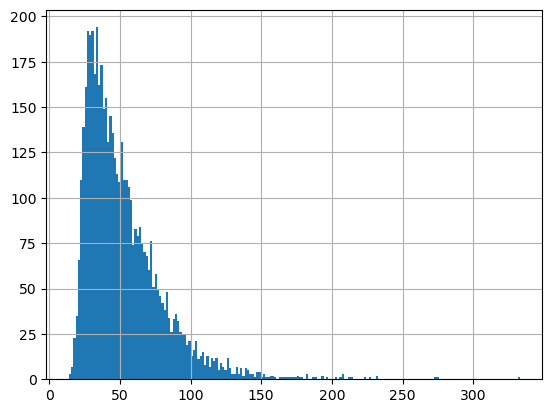

In [66]:
_ = simulated_values['VOT_public'].hist(bins=200)

In [67]:
avg_vot_pt = (
    simulated_values['VOT_public'] * 
    simulated_values['Weight']
).sum() / simulated_values['Weight'].sum()

avg_vot_pt

52.30076280503739

In [68]:
avg_vot_driving = (
    simulated_values['VOT_driving'] * 
    simulated_values['Weight']
).sum() / simulated_values['Weight'].sum()
avg_vot_driving

97.30850376597087

In [142]:
print('Original scenario:')
print(f'Average value of time for Public Transport: {avg_vot_pt:.2f} GBP/hour')
print(f'Average value of time for Driving: {avg_vot_driving:.2f} GBP/hour')

Original scenario:
Average value of time for Public Transport: 75.9 GBP/hour
Average value of time for Driving: 146 GBP/hour


In [143]:
# for the first scenario:
V_public = asc_public + beta_time_public * boxcox_time_3+ beta_cost * cost_transit 
V_driving = asc_driving + beta_time_driving * boxcox_time_4 + beta_cost * cost_driving*1.15 + beta_drivinglicense * driving_license +beta_traffic*driving_traffic_percent

vot_public = Derive(V_public,'dur_public') / Derive (V_public,'cost_transit')
vot_driving = Derive(V_driving,'dur_driving') / Derive (V_driving,'cost_driving')

simulate = {
    'Weight': Weight,
    'VOT_public': vot_public,
    'VOT_driving': vot_driving,
}
biosim = bio.BIOGEME(database, simulate)
simulated_values = biosim.simulate(results4.getBetaValues())


[23:59:43] < Warning >   Parameter MU_motorized not present in the model
[23:59:43] < Warning >   Parameter asc_cycling not present in the model
[23:59:43] < Warning >   Parameter beta_time_cycling not present in the model
[23:59:43] < Warning >   Parameter beta_time_walk not present in the model


In [144]:
avg_vot_pt = (
    simulated_values['VOT_public'] * 
    simulated_values['Weight']
).sum() / simulated_values['Weight'].sum()

avg_vot_pt

75.92543985852025

In [145]:
avg_vot_driving = (
    simulated_values['VOT_driving'] * 
    simulated_values['Weight']
).sum() / simulated_values['Weight'].sum()
avg_vot_driving

126.87289558495488

In [146]:
print('First scenario:')
print(f'Average value of time for Public Transport: {avg_vot_pt:.3g} GBP/hour')
print(f'Average value of time for Driving: {avg_vot_driving:.3g} GBP/hour')

First scenario:
Average value of time for Public Transport: 75.9 GBP/hour
Average value of time for Driving: 127 GBP/hour


In [147]:
# for the second scenario:
V_public = asc_public + beta_time_public * boxcox_time_3+ beta_cost * cost_transit*0.85 
V_driving = asc_driving + beta_time_driving * boxcox_time_4 + beta_cost * cost_driving + beta_drivinglicense * driving_license +beta_traffic*driving_traffic_percent

vot_public = Derive(V_public,'dur_public') / Derive (V_public,'cost_transit')
vot_driving = Derive(V_driving,'dur_driving') / Derive (V_driving,'cost_driving')

simulate = {
    'Weight': Weight,
    'VOT_public': vot_public,
    'VOT_driving': vot_driving,
}
biosim = bio.BIOGEME(database, simulate)
simulated_values = biosim.simulate(results4.getBetaValues())

[00:02:41] < Warning >   Parameter MU_motorized not present in the model
[00:02:41] < Warning >   Parameter asc_cycling not present in the model
[00:02:41] < Warning >   Parameter beta_time_cycling not present in the model
[00:02:41] < Warning >   Parameter beta_time_walk not present in the model


In [148]:
avg_vot_pt = (
    simulated_values['VOT_public'] * 
    simulated_values['Weight']
).sum() / simulated_values['Weight'].sum()
avg_vot_driving = (
    simulated_values['VOT_driving'] * 
    simulated_values['Weight']
).sum() / simulated_values['Weight'].sum()


145.9038268978126

In [149]:
print('First scenario:')
print(f'Average value of time for Public Transport: {avg_vot_pt:.3g} GBP/hour')
print(f'Average value of time for Driving: {avg_vot_driving:.3g} GBP/hour')

First scenario:
Average value of time for Public Transport: 89.3 GBP/hour
Average value of time for Driving: 146 GBP/hour


## Aggregate elasticity

Disaggregate elasticity
$$
E_{x_{i n k}}^{P_{n}(i)}=\frac{\partial P_{n}(i)}{\partial x_{i n k}} \frac{x_{i n k}}{P_{n}(i)}
$$
Aggregate elasticity
$$
\begin{aligned}
E_{x_{j k}}^{\widehat{x^{\prime}}(i)} & =\frac{\partial \widehat{W}(i)}{\partial x_{j k}} \frac{x_{j k}}{\widehat{W}(i)} \\
& =\frac{1}{S} \sum_{n=1}^{N} \omega_{n} \frac{P_{n}(i)}{P_{n}(i)} \frac{\partial P_{n}(i)}{\partial x_{j k}} \frac{S x_{j k}}{\sum_{\ell=1}^{N} \omega_{\ell} P_{\ell}(i)} \\
& =\frac{1}{\sum_{\ell=1}^{N} \omega_{\ell} P_{\ell}(i)} \sum_{n=1}^{N} \omega_{n} P_{n}(i) E_{x_{j n k}}^{P_{n}(i)} .
\end{aligned}
$$

In [150]:
from biogeme.expressions import Derive

In [157]:
def calculate_direct_elasticity(utility):
    
    prob_public = models.nested(utility, None, nests,3)
    prob_driving = models.nested(utility, None, nests,4)
    

    simulate = {
    'Weight': Weight,
    'Prob. public': prob_public,
    'Prob. driving': prob_driving,
    'Dis. Elas. public': Derive(prob_public,'cost_transit') * cost_transit / prob_public,
    'Dis. Elas. driving': Derive(prob_driving, 'cost_driving') * cost_driving / prob_driving,
    }


    biosim = bio.BIOGEME(database, simulate)
    simulated_values = biosim.simulate(results4.getBetaValues())
    
    simulated_values['Weighted public'] = simulated_values['Weight']*simulated_values['Prob. public']
    simulated_values['Weighted driving'] = simulated_values['Weight']*simulated_values['Prob. driving']
    
    norm_public = simulated_values['Weighted public'].sum()
    norm_driving = simulated_values['Weighted driving'].sum()

    Aggregate_elas_public = (simulated_values['Weighted public']*simulated_values['Dis. Elas. public']).sum()/norm_public
    Aggregate_elas_driving = (simulated_values['Weighted driving']*simulated_values['Dis. Elas. driving']).sum()/norm_driving

    return Aggregate_elas_public, Aggregate_elas_driving, norm_public, norm_driving

In [158]:
calculate_direct_elasticity(V)

(-0.04664386606950782,
 -0.04130276065239584,
 1813.2533804879056,
 2092.98908341553)

In [159]:
def calculate_cross_elasticity(utility):
    
    prob_public = models.nested(utility, None, nests,3)
    prob_driving = models.nested(utility, None, nests,4)
    

    simulate = {
    'Weight': Weight,
    'Prob. public': prob_public,
    'Prob. driving': prob_driving,
    'Dis. Elas. public': Derive(prob_public,'cost_driving') * cost_driving / prob_public,
    'Dis. Elas. driving': Derive(prob_driving, 'cost_transit') * cost_transit / prob_driving,
    }


    biosim = bio.BIOGEME(database, simulate)
    simulated_values = biosim.simulate(results4.getBetaValues())
    
    simulated_values['Weighted public'] = simulated_values['Weight']*simulated_values['Prob. public']
    simulated_values['Weighted driving'] = simulated_values['Weight']*simulated_values['Prob. driving']
    
    norm_public = simulated_values['Weighted public'].sum()
    norm_driving = simulated_values['Weighted driving'].sum()

    Aggregate_elas_public = (simulated_values['Weighted public']*simulated_values['Dis. Elas. public']).sum()/norm_public
    Aggregate_elas_driving = (simulated_values['Weighted driving']*simulated_values['Dis. Elas. driving']).sum()/norm_driving

    return Aggregate_elas_public, Aggregate_elas_driving

In [160]:
calculate_cross_elasticity(V)

(0.043672664188896544, 0.03596934468224017)